In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib

In [2]:
import os
from os.path import join
from glob import glob
import cv2
import argparse
import numpy as np
import json
from pprint import pprint

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('img_path', type=str, nargs='?', default=None)

config = args.parse_args()

flg_button = False

usage: ipykernel_launcher.py [-h] [img_path]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def check_dir():
    if config.img_path is None \
        or len(config.img_path) == 0 \
        or config.img_path == '' \
        or os.path.isdir(config.img_path):
        root = os.path.realpath('./')
        if os.path.isdir(config.img_path):
            root = os.path.realpath(config.img_path)
        img_list = sorted(glob(join(root, '*.png')))
        img_list.extend(sorted(glob(join(root, '*.jpg'))))
        config.img_path = img_list[0]

    img_dir = os.path.dirname(os.path.realpath(config.img_path))

    return img_dir

def move(pos, idx, img_list):
    if pos == 1:
        idx += 1
        if idx == len(img_list):
            idx = 0
    elif pos == -1:
        idx -= 1
        if idx == -1:
            idx = len(img_list) - 1
    return idx

In [3]:
# Mouse callback function
def select_point(event, x,y, flags, param):
    global flg_button, gparam
    img = gparam['img']

    if event == cv2.EVENT_LBUTTONDOWN:
        flg_button = True

    if event == cv2.EVENT_LBUTTONUP and flg_button == True:
        flg_button = False
        print (f'({x}, {y}), size:{img.shape}')
        gparam['point'] = [x,y]

랜드마크를 제공하는 데이터셋을 찾아보자
랜드마크를 제공하는 데이터셋을 찾아봅시다. 데이터를 어떻게 찾아가는지 함께 고민하는 것에 집중해주세요.

우리는 dlib 패키지의 얼굴 랜드마크를 사용해오고 있습니다. 그렇다면 dlib 패키지를 구현하기 위해 사용된 랜드마크는 어떤 데이터셋으로 학습되었을까? 를 생각해보면 간단히 데이터를 찾을 수 있습니다.

구글에 "dlib face landmark dataset"을 검색해봅시다. 검색 첫 페이지에서 아래 링크를 찾을 수 있습니다.

http://dlib.net/face_landmark_detection.py.html
주석을 몇 줄 읽어보면 어떤 데이터셋을 사용해서 학습했는지 친절하게 안내되어 있습니다.

In [4]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [13]:
list_image = sorted(glob(os.getenv('HOME')+'/aiffel/coarse_to_fine/data/train/input/img/*.png'))
list_label = sorted(glob(os.getenv('HOME')+'/aiffel/coarse_to_fine/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

IMAGE_SHAPE = (80, 120)
data_root = (os.getenv('HOME')+'/aiffel/coarse_to_fine/data/train/input')
label_root = (os.getenv('HOME')+'/aiffel/coarse_to_fine/data/train/label')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


(512, 512, 3)


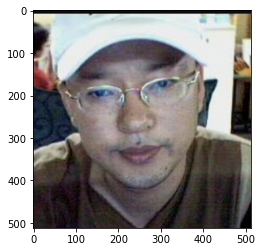

In [14]:
import os
img_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/images/kyb.png'
img = cv2.imread(img_path)
print (img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

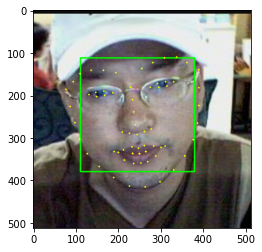

In [15]:
img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_model_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(dlib_model_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_rgb)
plt.show()

In [16]:
def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()
    
    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl
    
    ### if eye size is small
    if left_eye_size[1] < 7:
        margin = 1
    else:
        margin = 6
    
    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

(25, 62, 3)


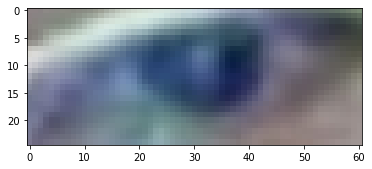

In [17]:

img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape)
plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]

    # smoothing
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1
    
    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1
    
    return [center_x, center_y]

In [19]:
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

In [20]:
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

(22, 11) (37, 13) (25, 62) (25, 61)


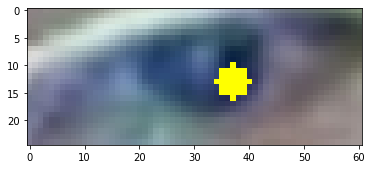

In [21]:
show = img_right_eye.copy()
    
show = cv2.circle(show, (right_center_x, right_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()


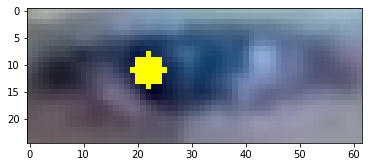

In [22]:
show = img_left_eye.copy()
    
show = cv2.circle(show, (left_center_x, left_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
!pip install tensorflow_hub # 설치되어 있지 않은 경우 주석 해제
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [24]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(80,120,3))

In [25]:
num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

In [38]:
IMAGE_SHAPE = (80, 120)


val_data_root = os.getenv('HOME')+'/aiffel/coarse_to_fine/data/val/input'
val_label_root = os.getenv('HOME')+'/aiffel/coarse_to_fine/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )